In [10]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import spagrn
from spagrn.network import Network  # Import the Network class
from spagrn import plot as prn
from pyscenic.aucell import aucell
from scipy.spatial.distance import jensenshannon

import sys
sys.path.insert(0, '/Users/linliu/NewSpaGRN/src/')
import importlib
import spagrn.hotspot
import spagrn.regulatory_network
importlib.reload(spagrn.hotspot)
importlib.reload(spagrn.regulatory_network)

# Load data
PDAC = ad.read_h5ad('/Users/linliu/Library/CloudStorage/Box-Box/linliu/PDAC/ad_PDAC/PDAC_SIMVI.h5ad')
print("Initial PDAC shape:", PDAC.shape)
print("Initial PDAC.obs_names:", PDAC.obs_names[:5])  # Show first 5 for brevity

# Preprocess data
PDAC.X = PDAC.layers['counts']
PDAC.layers['counts'] = PDAC.layers['counts'].tocsc()
PDAC.obs['total_counts'] = np.sum(PDAC.layers['counts'], axis=1)
sc.pp.normalize_total(PDAC, target_sum=1e4)
sc.pp.log1p(PDAC)
PDAC = Network.preprocess(PDAC, min_genes=10, min_cells=20, min_counts=20, max_gene_num=4000)
print("Post-preprocessing shape:", PDAC.shape)
print("Post-preprocessing obs_names:", PDAC.obs_names[:5])


# Load input files
tfs_fn = r'/Users/linliu/Library/CloudStorage/OneDrive-AugustaUniversity/GRN Analysis Input Resources/allTFs_hg38.txt'
database_fn = r'/Users/linliu/Library/CloudStorage/OneDrive-AugustaUniversity/GRN Analysis Input Resources/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'
motif_anno_fn = r'/Users/linliu/Library/CloudStorage/OneDrive-AugustaUniversity/GRN Analysis Input Resources/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl'
niches = pd.read_csv(r'/Users/linliu/Library/CloudStorage/OneDrive-AugustaUniversity/GRN Analysis Input Resources/lr_network_human.csv')

PDAC_subset = PDAC[np.random.choice(PDAC.n_obs, PDAC.n_obs // 100, replace=False), :].copy()
# Validate subset batches
min_cells_per_batch_subset = 50
batch_counts_subset = PDAC_subset.obs['patient'].value_counts()
valid_batches_subset = batch_counts_subset[batch_counts_subset >= min_cells_per_batch_subset].index
PDAC_subset = PDAC_subset[PDAC_subset.obs['patient'].isin(valid_batches_subset)].copy()
print("Post-subset batch filtering shape:", PDAC_subset.shape)
print("Final subset batch distribution:", PDAC_subset.obs['patient'].value_counts())

grn = spagrn.regulatory_network.InferNetwork(adata=PDAC_subset, project_name="PDAC_project")
grn.add_params({'num_workers':12, 'auc_threshold': 0.05})
grn.infer(
        database_fn,
        motif_anno_fn,
        tfs_fn,
        niche_df=niches,
        num_workers=1,
        cache=False,
        save_tmp=True,
        latent_obsm_key='spatial',
        model='bernoulli',
        n_neighbors=50,
        cluster_label='subleiden',
        layers='counts',
        umi_counts_obs_key="total_counts",
        batch_key='patient'
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Initial PDAC shape: (417793, 965)
Initial PDAC.obs_names: Index(['B10_1_1', 'B10_2_1', 'B10_3_1', 'B10_4_1', 'B10_5_1'], dtype='object')
Post-preprocessing shape: (417793, 965)
Post-preprocessing obs_names: Index(['B10_1_1', 'B10_2_1', 'B10_3_1', 'B10_4_1', 'B10_5_1'], dtype='object')
Post-subset batch filtering shape: (3532, 965)
Final subset batch distribution: W_B10       702
W_C4        625
W_D10       569
TMA28_F1    125
TMA32_D2    116
TMA28_E2     92
TMA28_F2     88
TMA31_C3     86
TMA31_F1     84
TMA31_B2     80
TMA32_A3     77
TMA28_B4     76
TMA28_A2     75
TMA32_C3     69
TMA32_D4     69
TMA28_F4     67
TMA31_F3     66
TMA32_F2     62
TMA1_H2      62
TMA31_E3     61
TMA28_F3     61
TMA1_G2      57
TMA28_B2     55
TMA31_D2     54
TMA1_G1      54
Name: patient, dtype: int64
----------------------------------------
Project name is PDAC_project
Batch correction enabled using key: patient
Savi

100%|██████████| 965/965 [00:01<00:00, 608.12it/s]


Computing batch-aware spatial weights with batch key: patient
Computing Moran's I...


/Users/linliu/miniconda3/envs/newspagrn/lib/python3.8/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 26 disconnected components.
  warnings.warn(message)
/Users/linliu/NewSpaGRN/src/spagrn/autocor.py:111: UserWarning: Weights matrix has 26 disconnected components. Consider increasing n_neighbors.
  warnings.warn(f"Weights matrix has {w.n_components} disconnected components. Consider increasing n_neighbors.")
/Users/linliu/miniconda3/envs/newspagrn/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


Computing Geary's C...


/Users/linliu/miniconda3/envs/newspagrn/lib/python3.8/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/linliu/NewSpaGRN/src/spagrn/c_autocor.py:191: UserWarning: Error computing Geary's C for gene AATK in batch TMA28_B4: operands could not be broadcast together with shapes (3800,) (3795,) 
  warnings.warn(f"Error computing Geary's C for gene {adata.var_names[gene_idx]} in batch {batch}: {e}")
/Users/linliu/NewSpaGRN/src/spagrn/c_autocor.py:191: UserWarning: Error computing Geary's C for gene ABL1 in batch TMA28_B4: operands could not be broadcast together with shapes (3800,) (3795,) 
  warnings.warn(f"Error computing Geary's C for gene {adata.var_names[gene_idx]} in batch {batch}: {e}")
/Users/linliu/NewSpaGRN/src/spagrn/c_autocor.py:191: UserWarning: Error computing Geary's C for gene ABL2 in batch TMA28_B4: operands could not be broadcast together with shapes (

Computing Getis G...


/Users/linliu/miniconda3/envs/newspagrn/lib/python3.8/site-packages/esda/getisord.py:173: RuntimeWarning: overflow encountered in long_scalars
  EG2DEN = ((sum(y) ** 2 - sum(y2)) ** 2) * n * (n - 1) * (n - 2) * (n - 3)
/Users/linliu/miniconda3/envs/newspagrn/lib/python3.8/site-packages/esda/getisord.py:128: RuntimeWarning: invalid value encountered in sqrt
  self.z_norm = (self.G - self.EG) / np.sqrt(self.VG)


global spatial gene num (intersection): 252
Current mode is moran
Using batch correction with batch key: patient


/Users/linliu/miniconda3/envs/newspagrn/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(

2025-09-09 16:15:12,272 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-09-09 16:15:12,274 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set 

run_in_parallel_m: Total time taken: 83.2689 seconds
[########################################] | 100% Completed | 79.13 s
Create regulons from a dataframe of enriched features.
Additional columns saved: []


100%|██████████| 38/38 [00:01<00:00, 37.99it/s]


Computing regulon specificity scores without batch correction


AnnData object with n_obs × n_vars = 3532 × 965
    obs: 'fov', 'sample', 'patient', 'pT', 'pN', 'tissue', 'paper', 'LVI', 'PNI', 'OS', 'x_mm', 'y_mm', 'subleiden', 'niche', 'n_counts', 'cancer_neighbor', 'plasma_neighbor', 'Grade', 'Apoptosis_score', 'Myogenesis_score', 'EMT_score', 'module_1_score', 'module_6_score', 'module_8_score', 'Plasma_ratio', 'Myeloid_ratio', 'fineleiden', 'censor', 'niche2', 'TIMP1_score', 'niche3', 'niche3_prop_Ductal', 'niche3_prop_CAF', 'niche3_prop_Acinar', 'niche3_prop_Pericyte', 'niche3_prop_T/NK', 'niche3_prop_Myeloid', 'niche3_prop_Mast cell', 'niche3_prop_Endocrine', 'niche3_prop_Plasma Niche (IgA/M)', 'niche3_prop_Cancer', 'niche3_prop_Neutrophil', 'niche3_prop_Endothelial', 'niche3_prop_SMC', 'niche3_prop_Plasma Niche (IgG)', 'niche3_prop_Plasma cell', 'subleiden_prop_Ductal', 'subleiden_prop_CAF', 'subleiden_prop_Acinar', 'subleiden_prop_Pericyte', 'subleiden_prop_T/NK', 'subleiden_prop_Myeloid', 'subleiden_prop_Mast cell', 'subleiden_prop_Endocr

In [70]:
PDAC_subset.uns['rss_batch_corrected']

False

In [31]:
PDAC_subset.obsm['auc_mtx']

Regulon,AR(+),ATF3(+),BATF3(+),ETS1(+),ETV4(+),ETV5(+),FOS(+),FOXF1(+),GATA3(+),IRF3(+),...,SMAD3(+),SMAD4(+),SOX4(+),SOX9(+),SREBF1(+),STAT1(+),STAT6(+),TBX21(+),TP53(+),TWIST1(+)
TMA31_4579_5,0.320692,0.087879,0.277481,0.086442,0.110120,0.009689,0.013822,0.059615,0.082434,0.168518,...,0.011796,0.106819,0.121970,0.013963,0.058110,0.051766,0.127421,0.139619,0.124195,0.036223
B10_2674_6,0.094818,0.067943,0.194313,0.096421,0.142753,0.045402,0.034154,0.011038,0.039379,0.043589,...,0.012413,0.190448,0.129631,0.051682,0.052628,0.041304,0.202335,0.187664,0.136474,0.016507
TMA1_2766_10,0.140977,0.068028,0.068336,0.097018,0.049449,0.040508,0.026297,0.000000,0.048673,0.092626,...,0.039126,0.059156,0.127296,0.073575,0.041004,0.051279,0.187727,0.089330,0.064538,0.003174
C4_3122_24,0.420592,0.187786,0.119937,0.096074,0.129157,0.035166,0.038582,0.004967,0.122150,0.238040,...,0.027085,0.145826,0.181185,0.051167,0.065662,0.040761,0.161443,0.259807,0.105301,0.001792
C4_2281_24,0.574008,0.139197,0.050724,0.029326,0.222111,0.038456,0.029894,0.037426,0.156261,0.328544,...,0.049908,0.116401,0.289263,0.075629,0.061736,0.058901,0.071382,0.177697,0.171902,0.015776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B10_2009_19,0.388717,0.311155,0.000000,0.037207,0.187937,0.049924,0.148310,0.013663,0.141974,0.160038,...,0.039421,0.183647,0.236837,0.095029,0.079039,0.054940,0.203858,0.450521,0.233417,0.001753
TMA28_1521_2,0.447025,0.167199,0.233963,0.055440,0.186863,0.060022,0.071539,0.008041,0.153778,0.184043,...,0.018138,0.112002,0.170019,0.100455,0.067654,0.078683,0.118878,0.221059,0.092768,0.000000
C4_2820_3,0.542071,0.155397,0.086698,0.033181,0.130384,0.038396,0.031346,0.000000,0.212236,0.276209,...,0.054239,0.040954,0.409119,0.072072,0.036467,0.082532,0.184799,0.415672,0.053345,0.001280
D10_1874_25,0.456025,0.166689,0.259919,0.108655,0.117799,0.031118,0.037268,0.033247,0.119488,0.169515,...,0.032555,0.173116,0.218566,0.047146,0.076775,0.055331,0.129771,0.169235,0.145362,0.026818


In [32]:
PDAC_subset.obsm['rep_auc_mtx']

,ANXA1,CD59,CTNNB1,EZR,FOS,JUNB,SOX9,XBP1,JUN
Cell,,,,,,,,,
TMA31_4579_5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B10_2674_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TMA1_2766_10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
C4_3122_24,0.005102,0.020737,0.018908,0.022167,0.022167,0.020737,0.022167,0.000000,0.022167
C4_2281_24,0.002551,0.002304,0.002101,0.002463,0.000000,0.002304,0.002463,0.003759,0.002463
...,...,...,...,...,...,...,...,...,...
B10_2009_19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TMA28_1521_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
C4_2820_3,0.017857,0.027650,0.044118,0.029557,0.034483,0.043779,0.029557,0.000000,0.029557


In [124]:
PDAC_subset.obsm['isr']

,AR(+),ATF3(+),BATF3(+),ETS1(+),ETV4(+),ETV5(+),FOS(+),FOXF1(+),GATA3(+),IRF3(+),...,SMAD3(+),SMAD4(+),SOX4(+),SOX9(+),SREBF1(+),STAT1(+),STAT6(+),TBX21(+),TP53(+),TWIST1(+)
TMA31_4579_5,0.320692,0.087879,0.277481,0.086442,0.110120,0.009689,0.013822,0.059615,0.082434,0.168518,...,0.011796,0.106819,0.121970,0.013963,0.058110,0.051766,0.127421,0.139619,0.124195,0.036223
B10_2674_6,0.094818,0.067943,0.194313,0.096421,0.142753,0.045402,0.034154,0.011038,0.039379,0.043589,...,0.012413,0.190448,0.129631,0.051682,0.052628,0.041304,0.202335,0.187664,0.136474,0.016507
TMA1_2766_10,0.140977,0.068028,0.068336,0.097018,0.049449,0.040508,0.026297,0.000000,0.048673,0.092626,...,0.039126,0.059156,0.127296,0.073575,0.041004,0.051279,0.187727,0.089330,0.064538,0.003174
C4_3122_24,0.420592,0.187786,0.119937,0.229408,0.129157,0.435166,0.038582,0.004967,0.122150,0.259093,...,0.093752,0.145826,0.181185,0.073390,0.065662,0.074095,0.161443,0.290577,0.105301,0.001792
C4_2281_24,0.574008,0.139197,0.050724,0.029326,0.222111,0.038456,0.029894,0.037426,0.156261,0.339070,...,0.049908,0.144972,0.303549,0.086740,0.061736,0.075567,0.071382,0.193081,0.238569,0.015776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B10_2009_19,0.388717,0.311155,0.000000,0.037207,0.187937,0.049924,0.148310,0.013663,0.141974,0.160038,...,0.039421,0.183647,0.236837,0.095029,0.079039,0.054940,0.203858,0.450521,0.233417,0.001753
TMA28_1521_2,0.447025,0.167199,0.233963,0.055440,0.186863,0.060022,0.071539,0.008041,0.153778,0.184043,...,0.018138,0.112002,0.170019,0.130084,0.067654,0.078683,0.118878,0.221059,0.092768,0.000000
C4_2820_3,0.542071,0.155397,0.108921,0.388737,0.130384,0.905062,0.031346,0.000000,0.212236,0.353402,...,0.232016,0.040954,0.409119,0.120220,0.036467,0.171421,0.234799,0.513108,0.053345,0.001280
D10_1874_25,0.456025,0.166689,0.259919,0.108655,0.117799,0.031118,0.037268,0.033247,0.119488,0.169515,...,0.032555,0.173116,0.218566,0.047146,0.076775,0.055331,0.129771,0.169235,0.145362,0.026818


In [35]:
PDAC_subset.uns['adj']

,TF,target,importance
0,PPARD,HLA-DRB1,0.021687
1,PPARD,IGF1,0.005850
2,PPARD,IGHG1,-0.005414
3,PPARD,ZFP36,0.016054
4,PPARD,KRT16,0.023461
...,...,...,...
19970,MAF,S100A6,0.007034
19971,MAF,PLAC8,0.006588
19972,MAF,B2M,0.023806
19973,MAF,LCN2,0.014600


In [235]:
print(min(PDAC_subset.uns['adj']['importance']))
print(max(PDAC_subset.uns['adj']['importance']))
print(np.quantile(PDAC_subset.uns['adj']['importance'], [0.25, 0.5, 0.75]))

-0.035872656920690575
0.21866318745159385
[0.00636353 0.01344711 0.02223377]


In [125]:
PDAC_subset.uns['rss']
 

,AR(+),ATF3(+),BATF3(+),ETS1(+),ETV4(+),ETV5(+),FOS(+),FOXF1(+),GATA3(+),IRF3(+),...,SMAD3(+),SMAD4(+),SOX4(+),SOX9(+),SREBF1(+),STAT1(+),STAT6(+),TBX21(+),TP53(+),TWIST1(+)
CAF,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,...,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334
Plasma cell,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,...,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334
T/NK,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,...,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334
SMC,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,...,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334
Cancer,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,...,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334
Acinar,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,...,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334
Ductal,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,...,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334
Endothelial,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,...,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334
Endocrine,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,...,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334
Pericyte,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,...,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334,-1.039334


In [74]:
PDAC_subset

AnnData object with n_obs × n_vars = 3532 × 965
    obs: 'fov', 'sample', 'patient', 'pT', 'pN', 'tissue', 'paper', 'LVI', 'PNI', 'OS', 'x_mm', 'y_mm', 'subleiden', 'niche', 'n_counts', 'cancer_neighbor', 'plasma_neighbor', 'Grade', 'Apoptosis_score', 'Myogenesis_score', 'EMT_score', 'module_1_score', 'module_6_score', 'module_8_score', 'Plasma_ratio', 'Myeloid_ratio', 'fineleiden', 'censor', 'niche2', 'TIMP1_score', 'niche3', 'niche3_prop_Ductal', 'niche3_prop_CAF', 'niche3_prop_Acinar', 'niche3_prop_Pericyte', 'niche3_prop_T/NK', 'niche3_prop_Myeloid', 'niche3_prop_Mast cell', 'niche3_prop_Endocrine', 'niche3_prop_Plasma Niche (IgA/M)', 'niche3_prop_Cancer', 'niche3_prop_Neutrophil', 'niche3_prop_Endothelial', 'niche3_prop_SMC', 'niche3_prop_Plasma Niche (IgG)', 'niche3_prop_Plasma cell', 'subleiden_prop_Ductal', 'subleiden_prop_CAF', 'subleiden_prop_Acinar', 'subleiden_prop_Pericyte', 'subleiden_prop_T/NK', 'subleiden_prop_Myeloid', 'subleiden_prop_Mast cell', 'subleiden_prop_Endocr

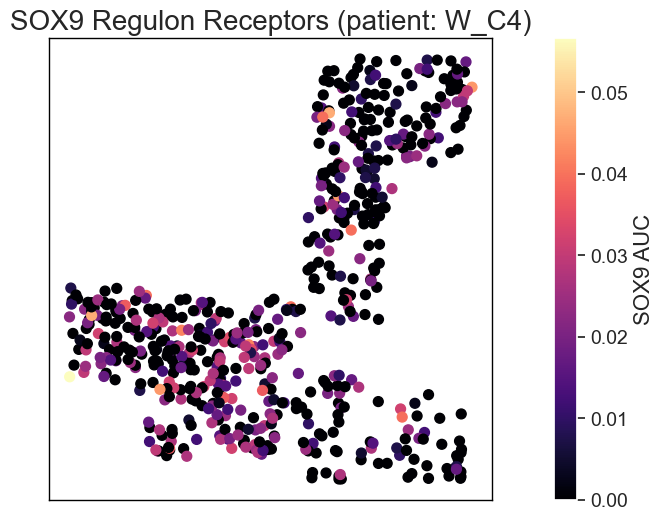

In [215]:
from spagrn.plot_Regulon import plot_spatial_auc

#Plot regulon receptors
plot_spatial_auc(PDAC_subset, 
                PDAC_subset.obsm['rep_auc_mtx'], 
                'SOX9', subset=True, subset_column='patient', sample='W_C4',
                dot_size=50, figure_size=(8, 6))


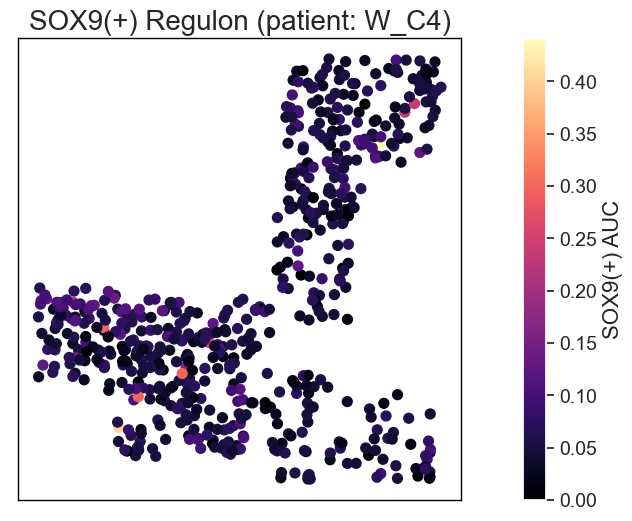

In [214]:
from spagrn.plot_Regulon import plot_spatial_auc

#Plot regulon in space
plot_spatial_auc(PDAC_subset, 
                PDAC_subset.obsm['auc_mtx'], 
                'SOX9(+)', spatial_layer='spatial', subset=True, subset_column='patient', sample='W_C4',
                dot_size=50, figure_size=(8, 6))

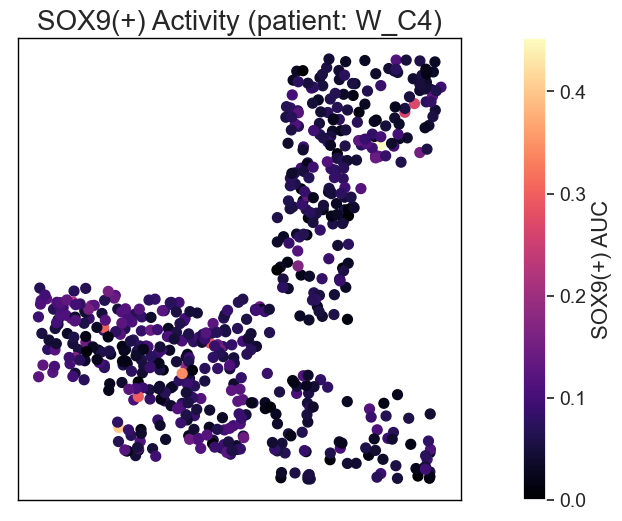

In [213]:
from spagrn.plot_Regulon import plot_spatial_auc

#Plot regulon in space
plot_spatial_auc(PDAC_subset, 
                PDAC_subset.obsm['isr'], 
                'SOX9(+)', spatial_layer='spatial', subset=True, subset_column='patient', sample='W_C4',
                dot_size=50, figure_size=(8, 6))


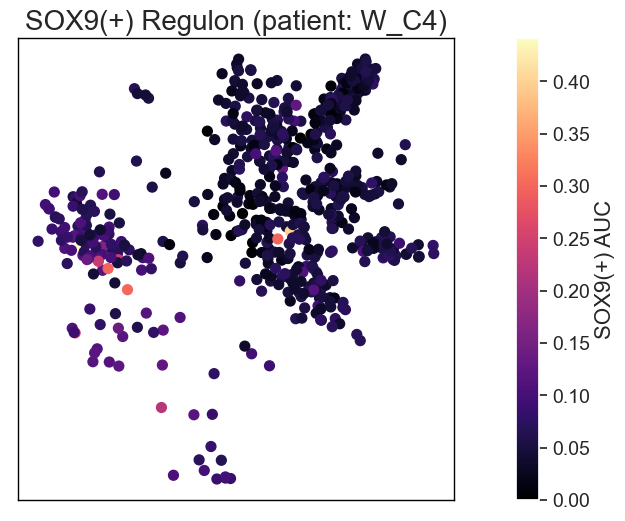

In [216]:
from spagrn.plot_Regulon import plot_spatial_auc

#Plot regulon in UMAP
plot_spatial_auc(PDAC_subset, 
                PDAC_subset.obsm['auc_mtx'], 
                'SOX9(+)', spatial_layer='X_umap', subset=True, subset_column='patient', sample='W_C4',
                dot_size=50, figure_size=(8, 6))


<Figure size 500x600 with 0 Axes>

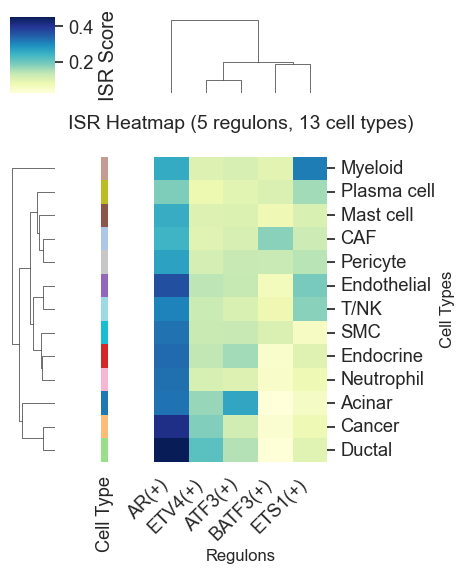

Heatmap created with:
  - 13 cell types: Acinar, CAF, Cancer, Ductal, Endocrine, Endothelial, Mast cell, Myeloid, Neutrophil, Pericyte, Plasma cell, SMC, T/NK
  - 5 regulons
  - Data range: 0.022 to 0.454


,AR(+),ETV4(+),BATF3(+),ETS1(+),ATF3(+)
Acinar,0.322719,0.166508,0.021780,0.051407,0.262960
CAF,0.240226,0.094950,0.175616,0.122657,0.106797
Cancer,0.411375,0.182479,0.035492,0.069233,0.115983
Ductal,0.454444,0.214678,0.026044,0.095501,0.143542
Endocrine,0.334371,0.133520,0.042053,0.097106,0.158047
Endothelial,0.365955,0.138306,0.062019,0.190321,0.130603
Mast cell,0.253260,0.098629,0.071533,0.105422,0.101598
Myeloid,0.255291,0.098340,0.090465,0.313845,0.106703
Neutrophil,0.326504,0.109538,0.044024,0.069453,0.098504
Pericyte,0.269987,0.112782,0.127534,0.141061,0.128990


In [207]:
# Show top 5 (ranked by rss) regulons per cell type
from spagrn.plot_Regulon import isr_heatmap

isr_heatmap(
    PDAC_subset,
    cluster_label='subleiden',
    isr_mtx=PDAC_subset.obsm['isr'],
    rss_df=PDAC_subset.uns['rss'],
    topn=5,  # Top 5 regulons per cell type
    figsize=(5, 6),
    cmap="YlGnBu",
    xticklabels=True,
    yticklabels=True
)

<Figure size 1700x600 with 0 Axes>

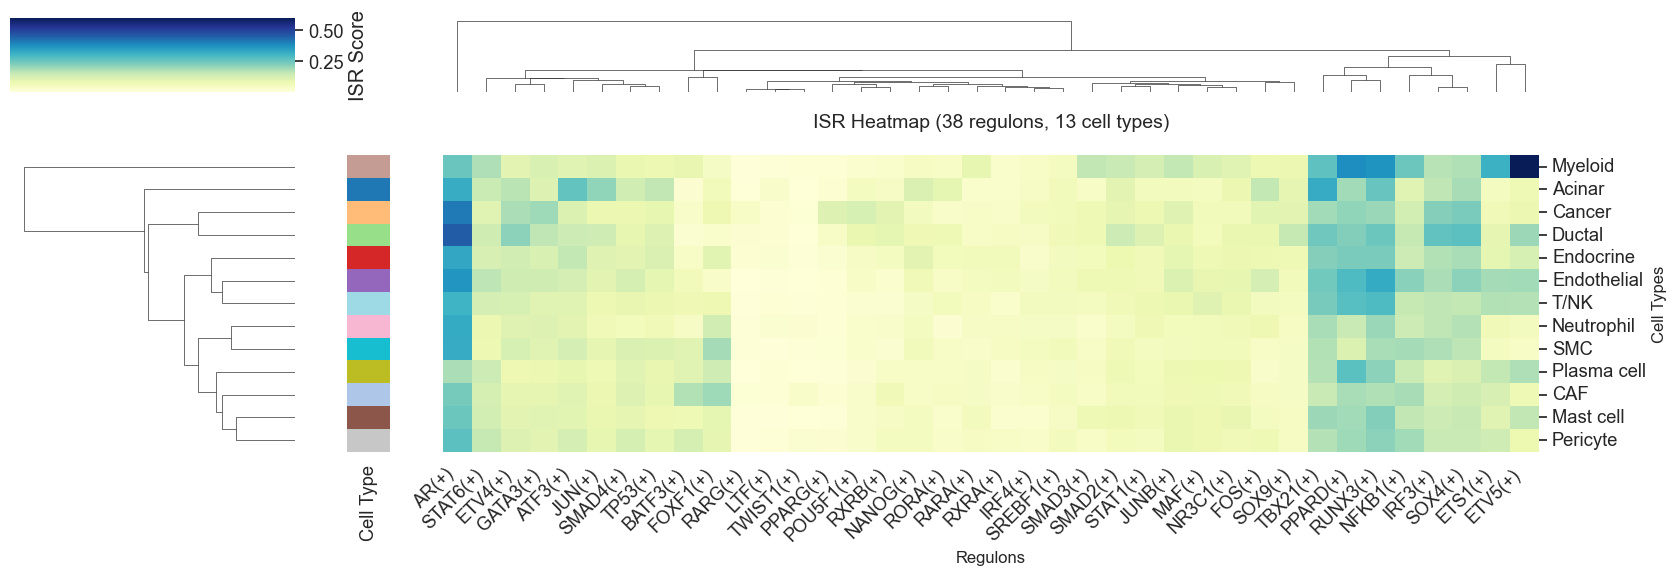

Heatmap created with:
  - 13 cell types: Acinar, CAF, Cancer, Ductal, Endocrine, Endothelial, Mast cell, Myeloid, Neutrophil, Pericyte, Plasma cell, SMC, T/NK
  - 38 regulons
  - Data range: 0.005 to 0.601


,AR(+),ATF3(+),BATF3(+),ETS1(+),ETV4(+),ETV5(+),FOS(+),FOXF1(+),GATA3(+),IRF3(+),...,SMAD3(+),SMAD4(+),SOX4(+),SOX9(+),SREBF1(+),STAT1(+),STAT6(+),TBX21(+),TP53(+),TWIST1(+)
Acinar,0.322719,0.262960,0.021780,0.051407,0.166508,0.071327,0.157151,0.063287,0.110144,0.162711,...,0.039010,0.137505,0.188605,0.094731,0.061154,0.057706,0.146911,0.324991,0.160759,0.011844
CAF,0.240226,0.106797,0.175616,0.122657,0.094950,0.070681,0.048415,0.196809,0.095178,0.129653,...,0.039671,0.110758,0.138250,0.045513,0.053365,0.061086,0.126569,0.149642,0.092378,0.035950
Cancer,0.411375,0.115983,0.035492,0.069233,0.182479,0.083223,0.102558,0.076634,0.197381,0.222753,...,0.072448,0.083583,0.234395,0.100220,0.061243,0.079177,0.104088,0.192254,0.093254,0.017281
Ductal,0.454444,0.143542,0.026044,0.095501,0.214678,0.198963,0.086192,0.030539,0.162245,0.264441,...,0.071798,0.093503,0.270231,0.155722,0.066425,0.111421,0.139468,0.249428,0.110147,0.011862
Endocrine,0.334371,0.158047,0.042053,0.097106,0.133520,0.125221,0.079007,0.101733,0.120549,0.177363,...,0.058679,0.100255,0.186496,0.071564,0.055066,0.067915,0.122942,0.223368,0.117592,0.013468
Endothelial,0.365955,0.130603,0.062019,0.190321,0.138306,0.191762,0.129535,0.037095,0.138920,0.184351,...,0.071197,0.126721,0.215593,0.065394,0.057354,0.068555,0.165579,0.246102,0.096477,0.010633
Mast cell,0.253260,0.101598,0.071533,0.105422,0.098629,0.159030,0.050214,0.096721,0.106001,0.144222,...,0.072540,0.094651,0.153468,0.048457,0.044594,0.070196,0.132055,0.200392,0.075762,0.010739
Myeloid,0.255291,0.106703,0.090465,0.313845,0.098340,0.601077,0.077901,0.045845,0.119681,0.172283,...,0.158876,0.087435,0.179581,0.082786,0.050728,0.130280,0.180276,0.267743,0.078044,0.015504
Neutrophil,0.326504,0.098504,0.044024,0.069453,0.109538,0.056079,0.076040,0.133691,0.111339,0.162025,...,0.032745,0.058697,0.174603,0.048047,0.045712,0.074296,0.082943,0.186012,0.065674,0.021431
Pericyte,0.269987,0.128990,0.127534,0.141061,0.112782,0.080435,0.071101,0.095853,0.100277,0.150281,...,0.038138,0.126637,0.150758,0.047321,0.057592,0.051887,0.154400,0.174171,0.097424,0.024186


In [206]:
# Show all regulons per cell type
from spagrn.plot_Regulon import isr_heatmap
isr_heatmap(
    PDAC_subset,
    cluster_label='subleiden',
    isr_mtx=PDAC_subset.obsm['isr'],  # Use directly - it's already a DataFrame
    rss_df=PDAC_subset.uns['rss'],
    topn=None,  # Show all regulons
    figsize=(17, 6),
    cmap="YlGnBu",
    xticklabels=True,
    yticklabels=True,
    row_cluster=True,
    col_cluster=True
)

Starting with ISR matrix shape: (3532, 38)
Regulon names: ['AR(+)', 'ATF3(+)', 'BATF3(+)', 'ETS1(+)', 'ETV4(+)']...
Added Acinar: 231 cells, mean range 0.010-0.325
Added CAF: 976 cells, mean range 0.015-0.240
Added Cancer: 828 cells, mean range 0.017-0.411
Added Ductal: 280 cells, mean range 0.012-0.454
Added Endocrine: 79 cells, mean range 0.013-0.334
Added Endothelial: 91 cells, mean range 0.005-0.366
Added Mast cell: 33 cells, mean range 0.008-0.253
Added Myeloid: 329 cells, mean range 0.009-0.601
Added Neutrophil: 77 cells, mean range 0.014-0.327
Added Pericyte: 89 cells, mean range 0.009-0.270
Added Plasma cell: 104 cells, mean range 0.007-0.271
Added SMC: 143 cells, mean range 0.008-0.325
Added T/NK: 272 cells, mean range 0.008-0.306
Heatmap data shape before filtering: (13, 38)
Data range: 0.005 to 0.601
Variance range: 0.000048 to 0.020974
Keeping 17 regulons with variance > 0.001
Final heatmap data shape: (13, 17)


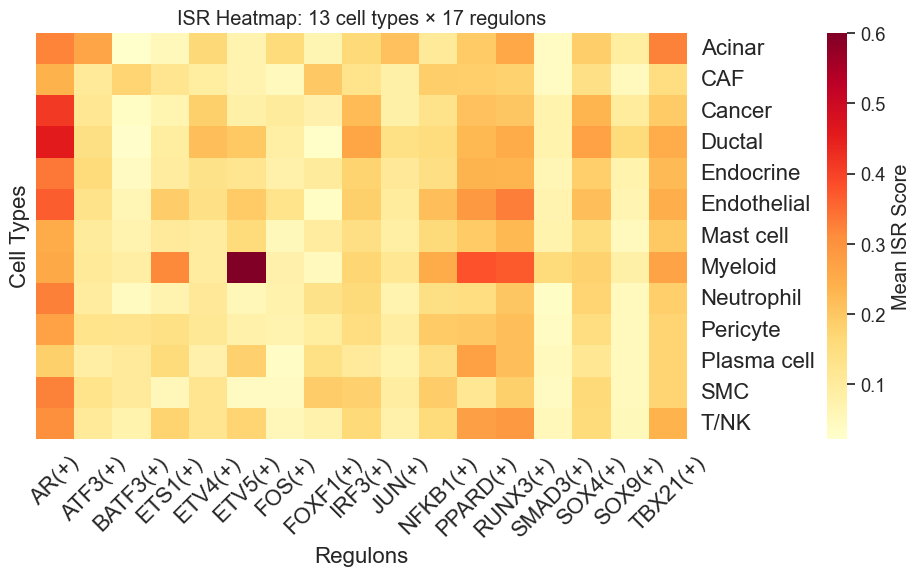

,AR(+),ATF3(+),BATF3(+),ETS1(+),ETV4(+),ETV5(+),FOS(+),FOXF1(+),IRF3(+),JUN(+),NFKB1(+),PPARD(+),RUNX3(+),SMAD3(+),SOX4(+),SOX9(+),TBX21(+)
Acinar,0.322719,0.262960,0.021780,0.051407,0.166508,0.071327,0.157151,0.063287,0.162711,0.211233,0.106663,0.191997,0.258086,0.039010,0.188605,0.094731,0.324991
CAF,0.240226,0.106797,0.175616,0.122657,0.094950,0.070681,0.048415,0.196809,0.129653,0.082126,0.187970,0.185001,0.178615,0.039671,0.138250,0.045513,0.149642
Cancer,0.411375,0.115983,0.035492,0.069233,0.182479,0.083223,0.102558,0.076634,0.222753,0.082741,0.132083,0.210369,0.201657,0.072448,0.234395,0.100220,0.192254
Ductal,0.454444,0.143542,0.026044,0.095501,0.214678,0.198963,0.086192,0.030539,0.264441,0.141024,0.154632,0.225874,0.253223,0.071798,0.270231,0.155722,0.249428
Endocrine,0.334371,0.158047,0.042053,0.097106,0.133520,0.125221,0.079007,0.101733,0.177363,0.108565,0.144676,0.235054,0.234461,0.058679,0.186496,0.071564,0.223368
Endothelial,0.365955,0.130603,0.062019,0.190321,0.138306,0.191762,0.129535,0.037095,0.184351,0.099016,0.218280,0.288737,0.327432,0.071197,0.215593,0.065394,0.246102
Mast cell,0.253260,0.101598,0.071533,0.105422,0.098629,0.159030,0.050214,0.096721,0.144222,0.086411,0.160065,0.192886,0.225606,0.072540,0.153468,0.048457,0.200392
Myeloid,0.255291,0.106703,0.090465,0.313845,0.098340,0.601077,0.077901,0.045845,0.172283,0.115496,0.250848,0.380838,0.372342,0.158876,0.179581,0.082786,0.267743
Neutrophil,0.326504,0.098504,0.044024,0.069453,0.109538,0.056079,0.076040,0.133691,0.162025,0.069826,0.143355,0.150763,0.202622,0.032745,0.174603,0.048047,0.186012
Pericyte,0.269987,0.128990,0.127534,0.141061,0.112782,0.080435,0.071101,0.095853,0.150281,0.092833,0.193181,0.198206,0.215684,0.038138,0.150758,0.047321,0.174171


In [208]:
# Try the improved simple heatmap
from spagrn.plot_Regulon import simple_isr_heatmap

simple_isr_heatmap(PDAC_subset, 
                   cluster_label='subleiden', 
                   figsize=(10, 6), 
                   min_variance=0.001) # Min variance threshold to filter out low-variance regulons

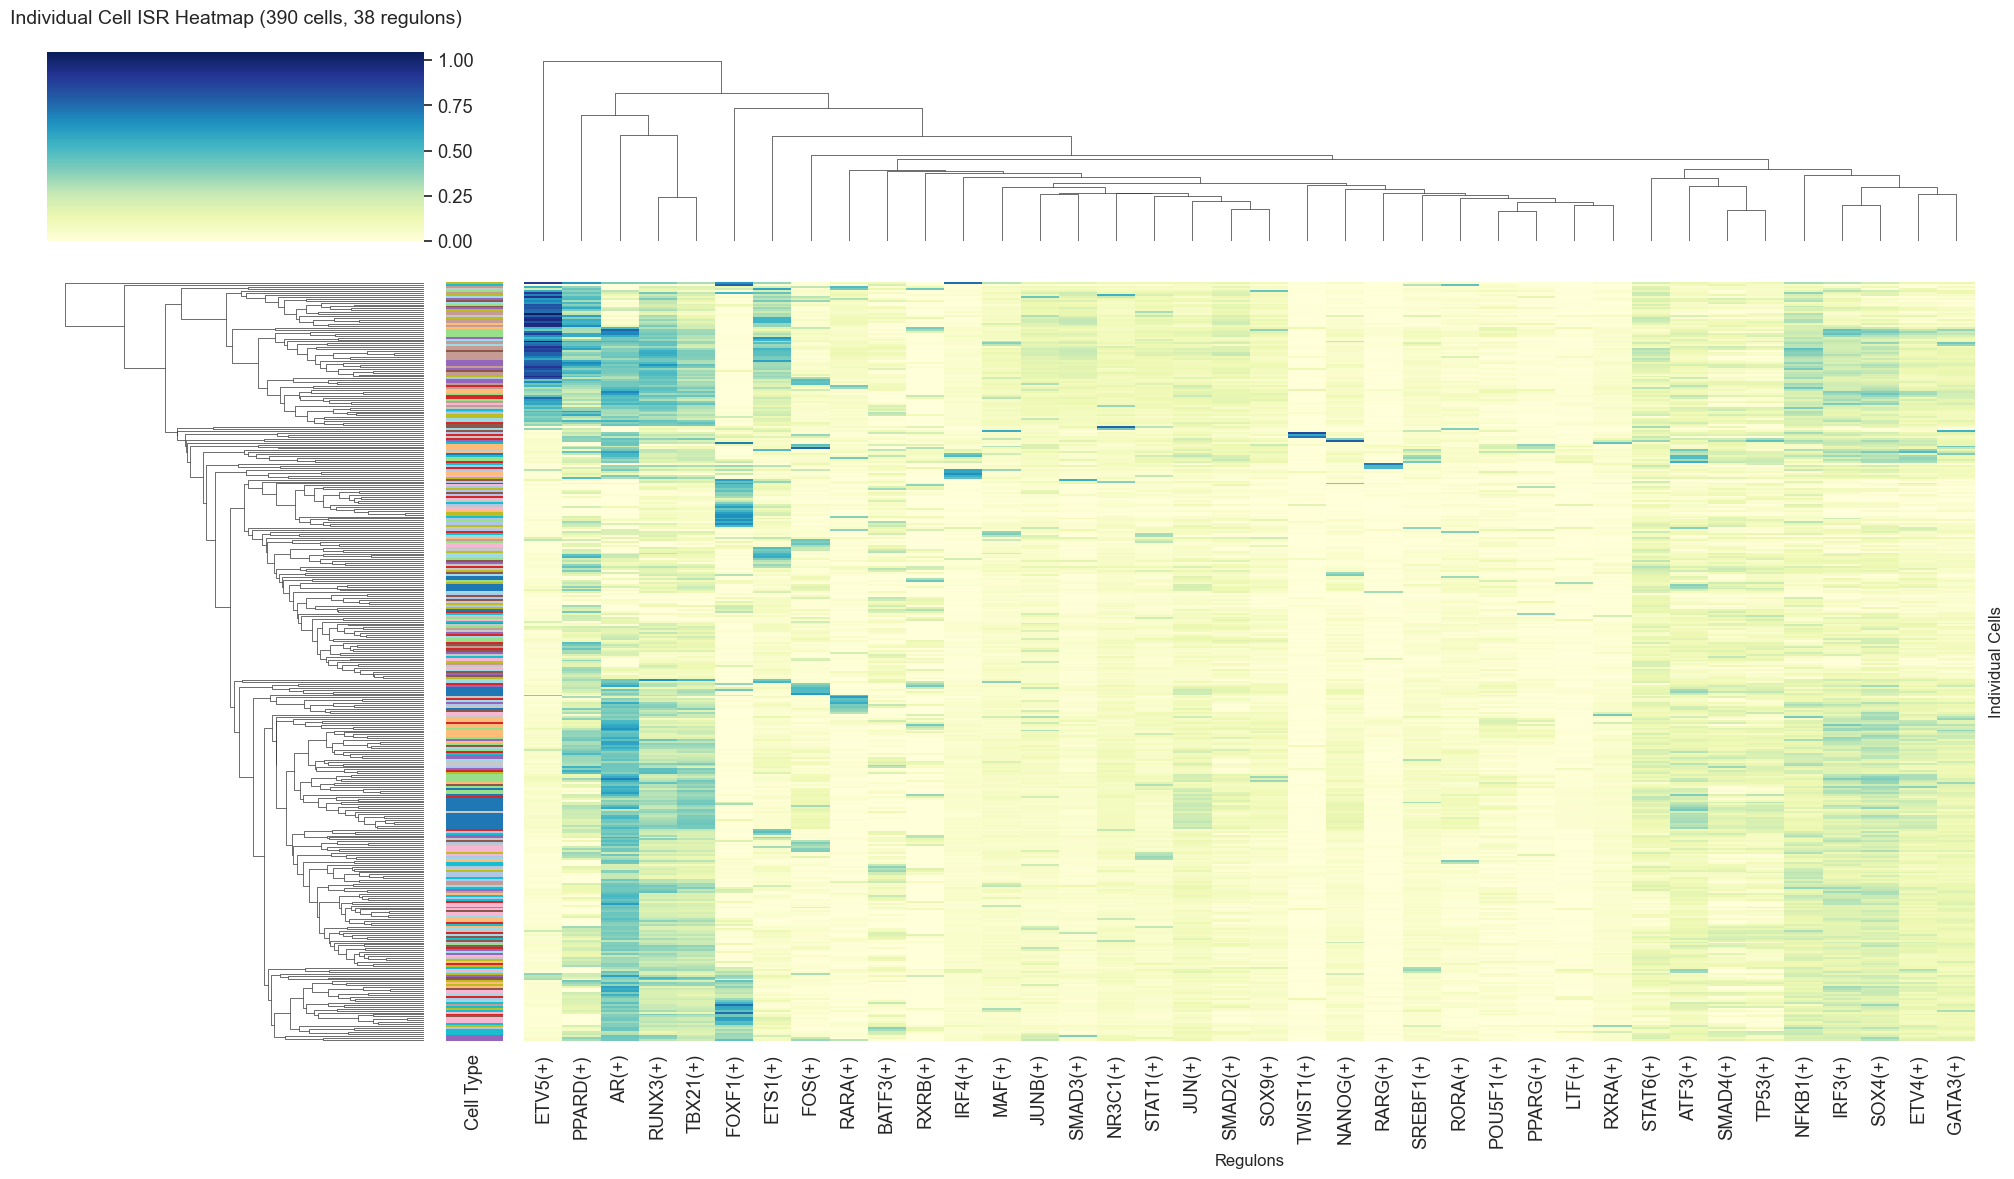

,AR(+),ATF3(+),BATF3(+),ETS1(+),ETV4(+),ETV5(+),FOS(+),FOXF1(+),GATA3(+),IRF3(+),...,SMAD3(+),SMAD4(+),SOX4(+),SOX9(+),SREBF1(+),STAT1(+),STAT6(+),TBX21(+),TP53(+),TWIST1(+)
TMA28_5764_19,0.167070,0.217584,0.014815,0.089986,0.095414,0.039577,0.496524,0.169484,0.081755,0.128970,...,0.053513,0.171099,0.145908,0.100824,0.017102,0.059665,0.144942,0.158054,0.193211,0.000000
C4_4321_12,0.504945,0.394162,0.000000,0.024613,0.172576,0.051774,0.145124,0.037556,0.175705,0.229251,...,0.046651,0.180258,0.239576,0.118951,0.057993,0.083486,0.155220,0.332126,0.281339,0.002081
TMA28_3727_19,0.334168,0.352804,0.013870,0.028764,0.222872,0.071038,0.485981,0.013294,0.114765,0.163558,...,0.030758,0.270500,0.239105,0.126100,0.061719,0.070953,0.158312,0.323566,0.271162,0.000000
B10_1228_3,0.281820,0.219986,0.020001,0.031233,0.178300,0.052481,0.108190,0.000000,0.111963,0.116027,...,0.042923,0.016667,0.183941,0.083977,0.074146,0.057219,0.266150,0.372261,0.055748,0.000000
B10_2531_21,0.496963,0.303887,0.000000,0.030516,0.254467,0.062313,0.118248,0.000000,0.179826,0.265024,...,0.035969,0.176393,0.320547,0.108617,0.060854,0.055797,0.182567,0.396036,0.139261,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B10_96_7,0.359563,0.050432,0.077682,0.116584,0.119966,0.021672,0.008640,0.428438,0.092426,0.155052,...,0.016762,0.076702,0.146278,0.036261,0.032759,0.034971,0.067375,0.189650,0.099419,0.011371
TMA1_1512_10,0.038880,0.050992,0.000000,0.242600,0.053167,0.622891,0.046345,0.000000,0.031938,0.072788,...,0.101967,0.183865,0.043399,0.060301,0.012583,0.091268,0.122187,0.079405,0.098453,0.000000
TMA31_2134_10,0.163392,0.085052,0.060176,0.509999,0.049754,0.043875,0.059366,0.000000,0.075288,0.148263,...,0.023032,0.187271,0.161311,0.046966,0.012225,0.041017,0.078338,0.144329,0.102049,0.000000
TMA1_2766_10,0.140977,0.068028,0.068336,0.097018,0.049449,0.040508,0.026297,0.000000,0.048673,0.092626,...,0.039126,0.059156,0.127296,0.073575,0.041004,0.051279,0.187727,0.089330,0.064538,0.003174


In [209]:
# Show individual cells heatmap
from spagrn.plot_Regulon import create_individual_cell_heatmap

create_individual_cell_heatmap(
    PDAC_subset,
    cluster_label='subleiden',
    max_cells_per_type=30, #number of individual cells plotted for each cell type
    figsize=(20, 12),
    cmap="YlGnBu"
    )

In [258]:
PDAC_subset.uns['receptor_dict']['ETV5']

['CD74']

In [ ]:
# Get network (TF->Target) significance range
import numpy as np
from spagrn.plot_GRN import get_network_summary

# Get the network summary
summary = get_network_summary(PDAC_subset, receptor_source='receptor_dict')

# Extract and print the importance range
min_importance = summary.get('min_importance', None)
max_importance = summary.get('max_importance', None)

if min_importance is not None and max_importance is not None:
    print(f"Importance Range: {min_importance} to {max_importance}")
else:
    print("No importance data found in adata.uns['adj']")

Importance Range: -0.035872656920690575 to 0.21866318745159385


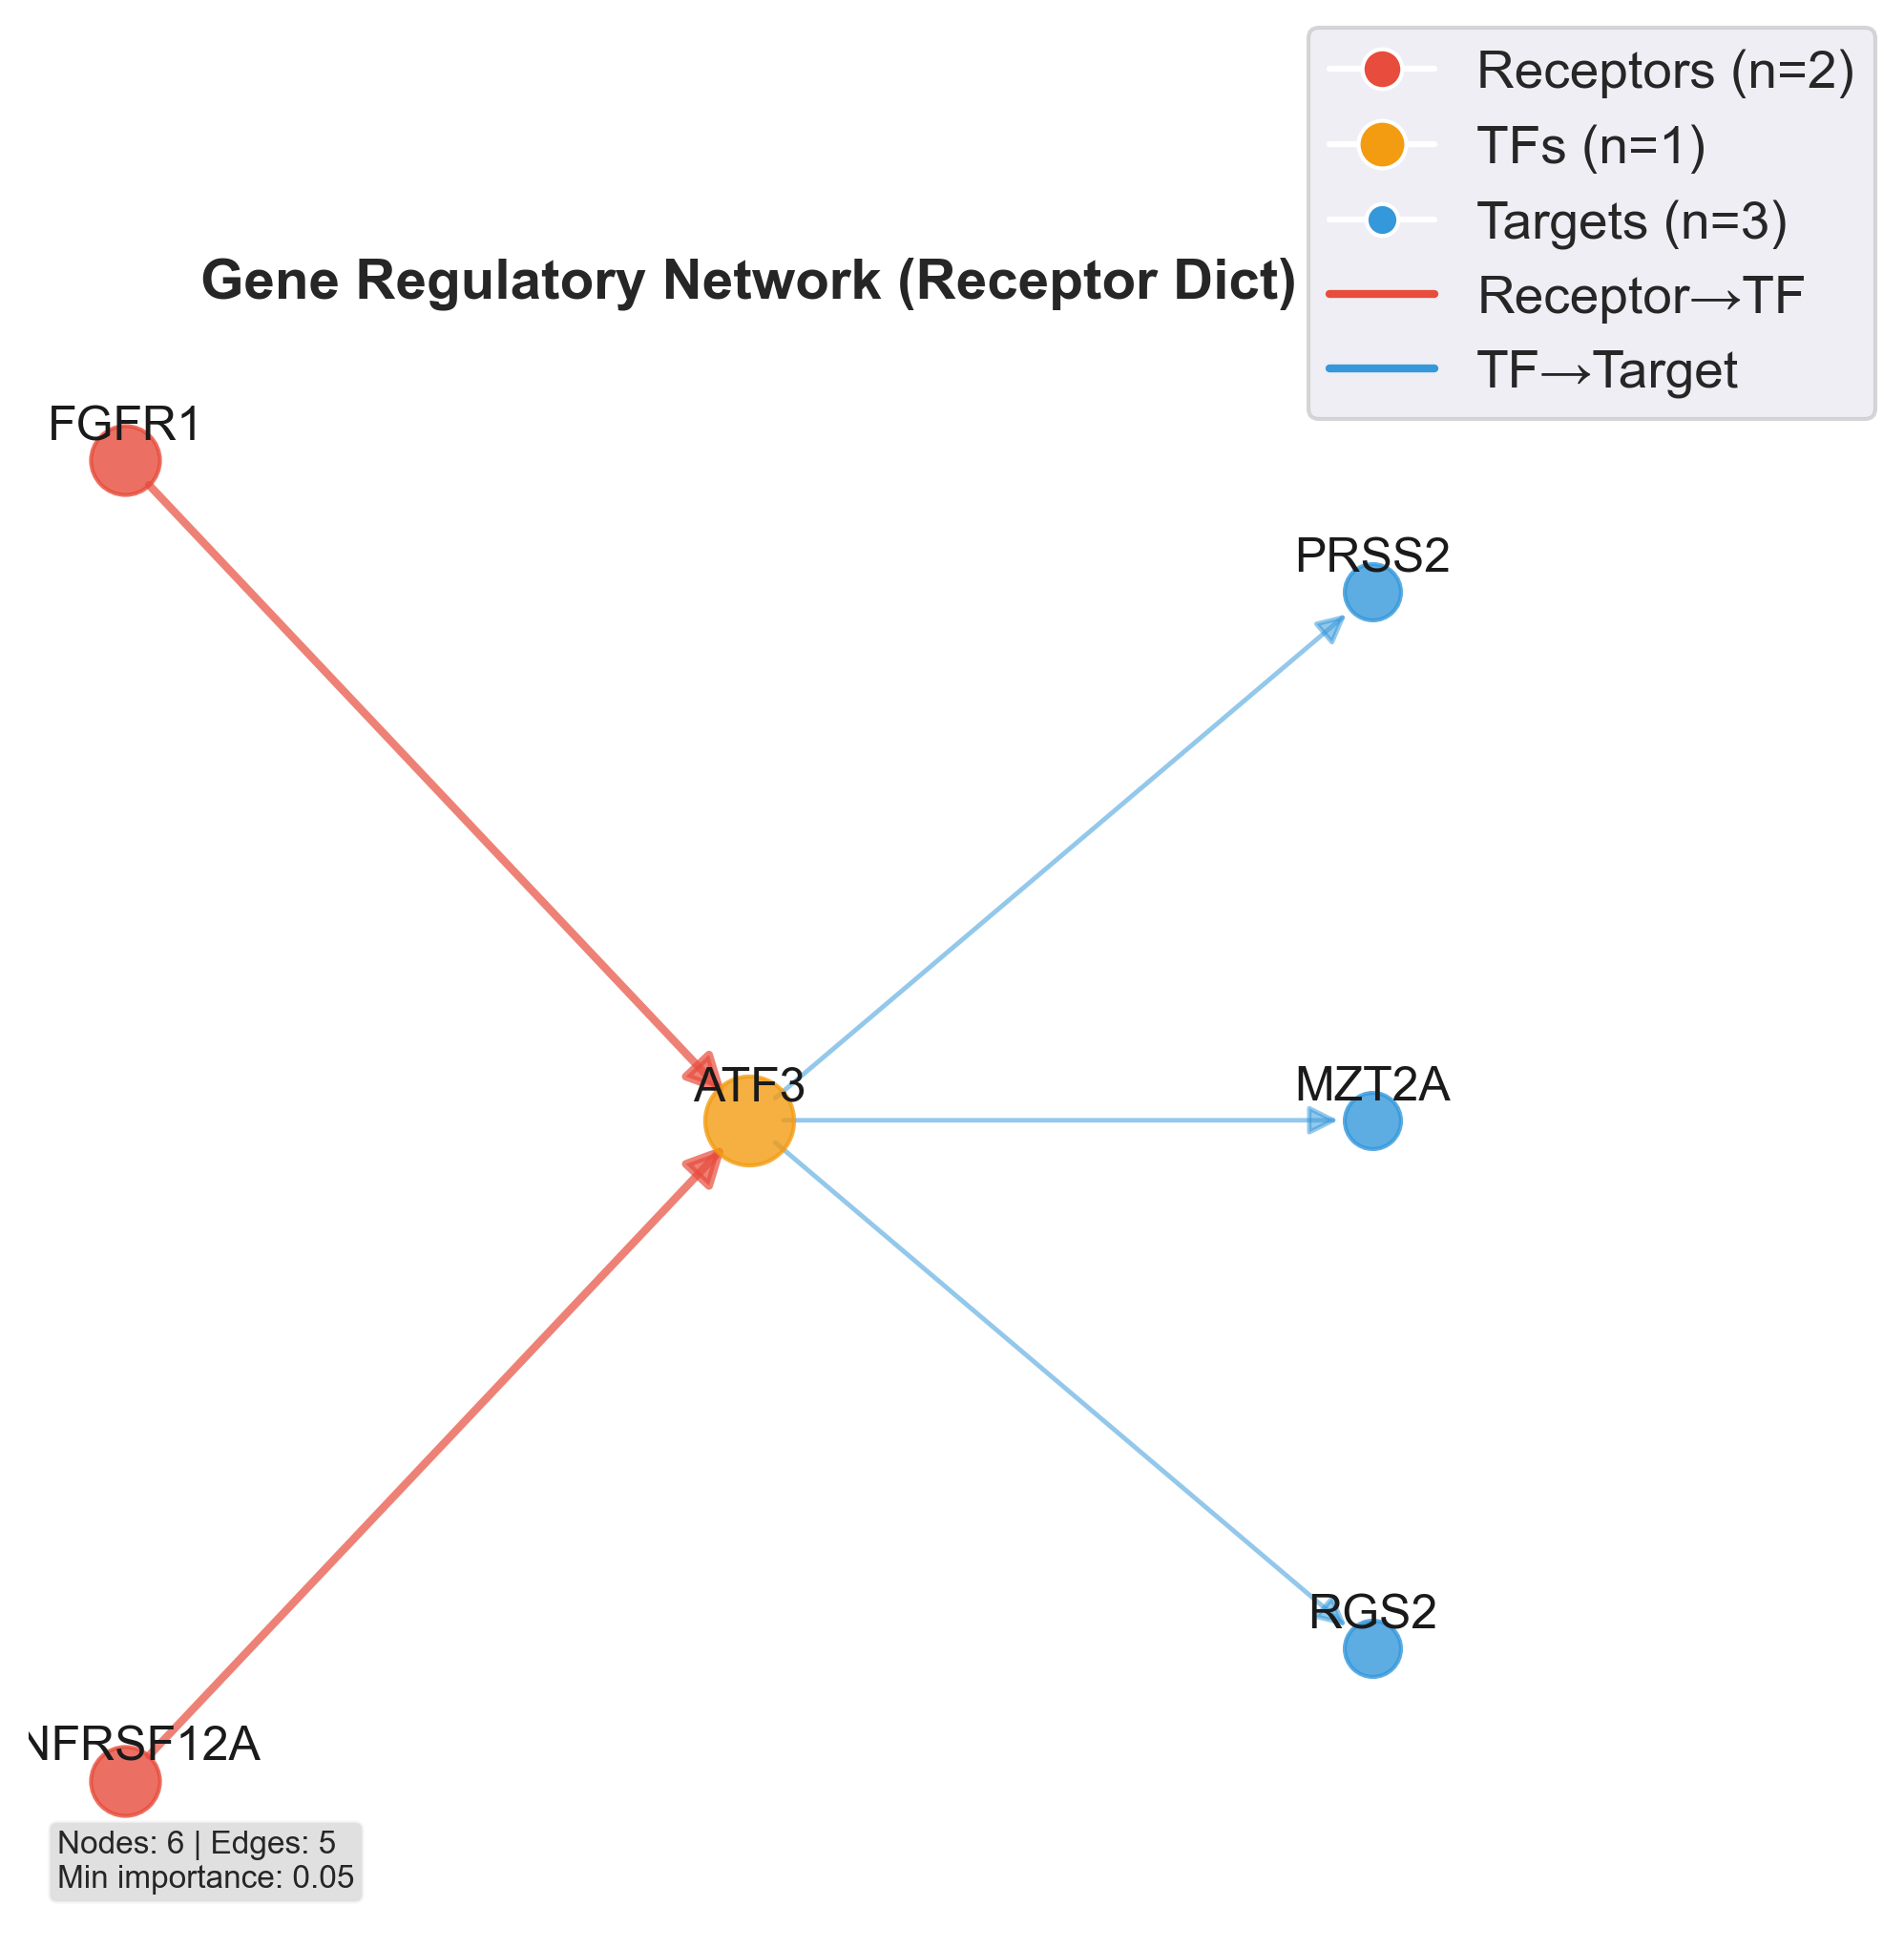

In [ ]:
# Focus on specific TFs 
fig, G = plot_grn_network(
    PDAC_subset,
    receptor_source='receptor_dict',
    selected_tfs=['ATF3',],
    min_importance=0.05,
    )